Fetching options data for 2024-02-09
Fetching options data for 2024-02-16
Fetching options data for 2024-02-23
Fetching options data for 2024-03-01
Fetching options data for 2024-03-08
Fetching options data for 2024-03-15
Fetching options data for 2024-03-22
Fetching options data for 2024-04-19
Fetching options data for 2024-05-17
Fetching options data for 2024-06-21
Fetching options data for 2024-07-19


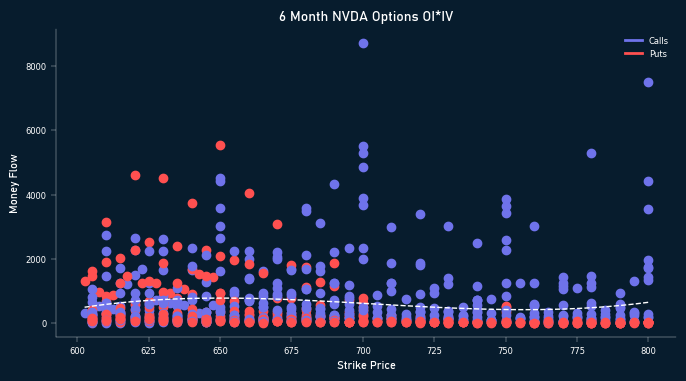

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Fetch options data for AMD
ticker = yf.Ticker('NVDA')

# Get the current price of the stock
current_price = ticker.history(period="1d")["Close"][0]

# Get available expiration dates for the next six months
expirations = ticker.options
current_date = datetime.now()
six_months_later = current_date + timedelta(days=180)
available_expirations = [exp_date for exp_date in expirations if current_date <= datetime.strptime(exp_date, '%Y-%m-%d') <= six_months_later]

data = []

# Fetch option chain for each available expiration date within the next six months
for exp_date in available_expirations:
    try:
        option_chain = ticker.option_chain(exp_date)
        if len(option_chain) != 3:
            raise ValueError("Expected exactly 3 items (calls, puts, and possibly other data) in option chain, but received {}.".format(len(option_chain)))
        calls, puts, _ = option_chain
    except Exception as e:
        print(f"Error retrieving options for {exp_date}: {e}")
        continue

    factor = current_price / 7
    lower = current_price - factor
    upper = current_price + factor

    print(f"Fetching options data for {exp_date}")
    
    for option_type, marker, color in zip([calls, puts], ['o', 'o'], ['#6F73EB', '#FF5050']):
        for index, row in option_type.iterrows():
            strike_price = row['strike']
            if lower <= strike_price <= upper:
                data.append([strike_price, row['openInterest'], row['impliedVolatility'], row['openInterest'] * row['impliedVolatility'], marker, color])

# Convert the data to a DataFrame and create a scatter plot
df = pd.DataFrame(data, columns=['Strike', 'Open Interest', 'Implied Volatility', 'OI * IV', 'Marker', 'Color'])

# Fit a polynomial curve to the data
z = np.polyfit(df['Strike'], df['OI * IV'], 3)
p = np.poly1d(z)

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor('#071C2D')
ax.set_facecolor('#071C2D')

# Customize the plot
plt.title(f'6 Month {ticker.ticker} Options OI*IV', fontsize=10, fontweight='bold', color='white', family='Bahnschrift')
plt.xlabel('Strike Price', color='white', family='Bahnschrift', fontsize=8)
plt.ylabel('Money Flow', fontsize=8, family='Bahnschrift', color='white')
ax.tick_params(axis='x', colors='white', labelsize=6)
ax.tick_params(axis='y', colors='white', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_linewidth(0.25)
ax.spines['left'].set_linewidth(0.25)
ax.tick_params(axis='x', colors='white', width=0.25)
ax.tick_params(axis='y', colors='white', width=0.25)
legend_labels = ['Calls', 'Puts']
legend_handles = [plt.Line2D([0], [0], color='#6F73EB', lw=2), plt.Line2D([0], [0], color='#FF5050', lw=2)]
ax.legend(legend_handles, legend_labels, loc='upper right', fontsize=6, labelcolor='white', facecolor='#071C2D', framealpha=0.0, edgecolor='white')

# Create scatter plot
for index, row in df.iterrows():
    plt.scatter(row['Strike'], row['OI * IV'], marker=row['Marker'], color=row['Color'])

# Plot trendline
x = np.linspace(df['Strike'].min(), df['Strike'].max(), 100)
plt.plot(x, p(x), color='white', linestyle='--', linewidth=1)

# Show the plot
plt.show()